# Project 2  Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)


**Resources:**
- LDA:
    - https://medium.com/sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06 
    - https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%9A-Topic-Modeling (code for previous post)
    - https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf/ 
- BERTopic:
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_documents.html#visualize-documents-with-plotly 
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html 


In [1]:
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

/srv/conda/envs/sotu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#from nlp-P03
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sou = pd.read_csv(
Path.home() / "proj02-group08" / "data" / "00_raw" / "SOTU.csv"
)

plt.style.use('seaborn-v0_8-dark')

In [3]:
#from nlp-P03
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

### LDA

- Train an LDA model with 18 topics
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization

You may use the next two cells to process the data.

In [4]:
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]


In [5]:
# Process all texts - note this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

To train an LDA model, use the LdaModel function that we imported a couple of cells back. The last resource linked under the LDA section is especially useful for walking through the steps we have below. *Note: one of the arguments to the LdaModel function is `random_state` which specifies the random seed for reproducibility. Please set yours to 42. Further, the last resource provided uses `LdaMulticore` which is essentially a parallelizable version of our function `LdaModel`. Use `LdaModel` instead, but the usage will be similar, except you can ignore the `iterations` and `workers` arguments..*.

In [6]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
dictionary = Dictionary(processed_docs)

corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [7]:
# train LDA model with 18 topics
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=18,
    random_state=42
)

In [8]:
# print the top 10 words for each topic
for topic_id in range (lda_model.num_topics):
    print(f"Topic {topic_id}")
    print(lda_model.print_topic(topic_id, topn=10))
    print("__" * 30)

Topic 0
0.012*"government" + 0.008*"united" + 0.008*"states" + 0.007*"country" + 0.007*"year" + 0.006*"congress" + 0.005*"public" + 0.004*"great" + 0.004*"people" + 0.004*"nation"
____________________________________________________________
Topic 1
0.009*"year" + 0.008*"government" + 0.008*"people" + 0.007*"states" + 0.006*"congress" + 0.006*"country" + 0.005*"great" + 0.005*"nation" + 0.005*"united" + 0.005*"time"
____________________________________________________________
Topic 2
0.008*"year" + 0.007*"states" + 0.007*"government" + 0.006*"congress" + 0.006*"united" + 0.005*"people" + 0.005*"great" + 0.004*"public" + 0.004*"service" + 0.004*"increase"
____________________________________________________________
Topic 3
0.010*"year" + 0.009*"states" + 0.008*"government" + 0.007*"congress" + 0.007*"great" + 0.006*"nation" + 0.005*"united" + 0.005*"time" + 0.005*"people" + 0.005*"country"
____________________________________________________________
Topic 4
0.011*"government" + 0.008*"st

In [9]:
# print the topic distribution for the first speech
first_doc_bow = corpus[0]
first_doc_topics = lda_model.get_document_topics(first_doc_bow)

for topic_id, prob in first_doc_topics:
    print(f"Topic {topic_id}: {prob:.4f}")

Topic 1: 0.0196
Topic 3: 0.0218
Topic 6: 0.0219
Topic 7: 0.9343


In [10]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.000318  0.003795       1        1  21.972104
0      0.005459  0.001584       2        1  21.915564
10    -0.001930  0.000058       3        1  17.025325
7     -0.001968  0.003789       4        1   9.414606
3     -0.004466  0.002130       5        1   6.872681
8      0.006430 -0.000534       6        1   5.132954
16    -0.001952  0.001561       7        1   3.870633
4      0.005082 -0.001057       8        1   3.237185
12     0.002609  0.000544       9        1   2.262527
9      0.002564 -0.000885      10        1   2.222927
2     -0.001182 -0.000364      11        1   2.198004
17    -0.001606  0.001720      12        1   2.154839
13    -0.000616 -0.000664      13        1   0.749428
1     -0.005639 -0.001971      14        1   0.368789
11     0.004520 -0.002598      15        1   0.342270
5     -0.001600  0.000196      16        1   0.202704
15    -0.000319 -0.002486      17        1   0.033061
14    -0.005068 -0.004818      18        1   0.024399, topic_info=            Term         Freq        Total Category  logprob  loglift
1525  government  8605.000000  8605.000000  Default  30.0000  30.0000
1250        year  6457.000000  6457.000000  Default  29.0000  29.0000
1066      states  6552.000000  6552.000000  Default  28.0000  28.0000
223     congress  5381.000000  5381.000000  Default  27.0000  27.0000
246      country  4889.000000  4889.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1065       state     0.554147  2692.657455  Topic18  -5.8787  -0.1702
856      present     0.556185  2795.374842  Topic18  -5.8750  -0.2040
958        right     0.516932  2585.670714  Topic18  -5.9482  -0.1992
5000     subject     0.454733  1962.017590  Topic18  -6.0764  -0.0514
801        peace     0.454171  2103.466126  Topic18  -6.0776  -0.1222

[1678 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9256      1  0.152345     --to
9256      2  0.152345     --to
9256      3  0.152345     --to
9256      4  0.152345     --to
9256      5  0.076172     --to
...     ...       ...      ...
1250     17  0.000310     year
1250     18  0.000155     year
7120      1  0.235750  yeltsin
7120      2  0.235750  yeltsin
7120      3  0.235750  yeltsin

[7389 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 11, 8, 4, 9, 17, 5, 13, 10, 3, 18, 14, 2, 12, 6, 16, 15])

### BERTopic

- Train a BERTopic model with a `min_topic_size` of 3 *Hint: use `BERTopic` to instantiate the model and specify `min_topic_size` in here. Actually fit the model using `fit_transform`, which `docs` passed into this.*
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization of the topics (see topic_model.visualize_topics())

In [11]:
docs = sou['Text'].to_list()

In [12]:
# train the model - this takes about 30 seconds
topic_model = BERTopic(min_topic_size=3)
topics, probs = topic_model.fit_transform(docs)

# remove stop words from the topics (Hint: use CountVectorizer and then .update_topics on topic_model)
vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, topics=topics, vectorizer_model=vectorizer_model)

2025-11-22 04:42:06,030 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [13]:
# output the top 10 words for each topic - hint see get_topic_info
topic_info = topic_model.get_topic_info()

for topic_id in topic_info["Topic"]:
    if topic_id == -1:
        continue
    print(f"Topic {topic_id}")
    print(topic_model.get_topic(topic_id)[:10])  # list of (word, weight) for top 10
    print("__" * 30)

Topic 0
[('world', np.float64(0.018692484490989775)), ('people', np.float64(0.01766220140252772)), ('new', np.float64(0.017325811926961247)), ('years', np.float64(0.01706656336376882)), ('america', np.float64(0.016008392575356044)), ('american', np.float64(0.015048556165634637)), ('year', np.float64(0.014786959943719858)), ('americans', np.float64(0.012560924818413746)), ('congress', np.float64(0.012375715296412593)), ('nation', np.float64(0.012251076871542208))]
____________________________________________________________
Topic 1
[('states', np.float64(0.02093976743064529)), ('government', np.float64(0.018399723508775993)), ('united', np.float64(0.01767005804266681)), ('congress', np.float64(0.014237315812273063)), ('public', np.float64(0.013353654360012913)), ('great', np.float64(0.011642804605751424)), ('shall', np.float64(0.011052491822265819)), ('country', np.float64(0.010964595266725344)), ('department', np.float64(0.01080369464132828)), ('state', np.float64(0.010424940289925992)

Topic 0: 0.1565
Topic 1: 0.0221
Topic 2: 0.1966
Topic 3: 0.1752
Topic 4: 0.0329
Topic 5: 0.0566
Topic 6: 0.0231
Topic 7: 0.0363
Topic 8: 0.0256
Topic 9: 0.0221
Topic 10: 0.0198
Topic 11: 0.0197
Topic 12: 0.0102
Topic 13: 0.0157
Topic 14: 0.0137
Topic 15: 0.0408
Topic 16: 0.0253
Topic 17: 0.0140
Topic 18: 0.0298
Topic 19: 0.0249
Topic 20: 0.0262
Topic 21: 0.0129


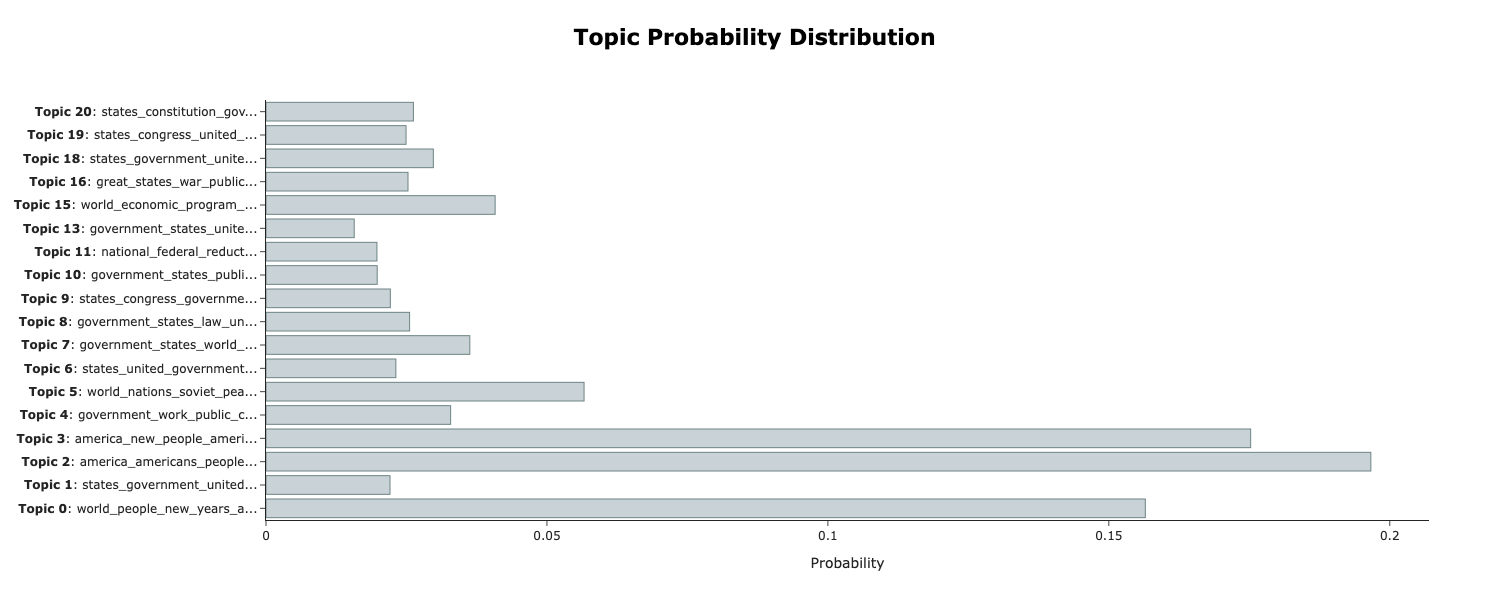

In [14]:
# output the topic distribution for the first speech
# hint: check out approximate_distribution() and visualize_distribution()
probs_first = topic_model.approximate_distribution([docs[0]])[0]
probs_first = probs_first.flatten()   # ← FIX: makes it 1D properly

for topic_id, prob in enumerate(probs_first):
    if prob > 0:
        print(f"Topic {topic_id}: {prob:.4f}")

topic_model.visualize_distribution(probs_first)

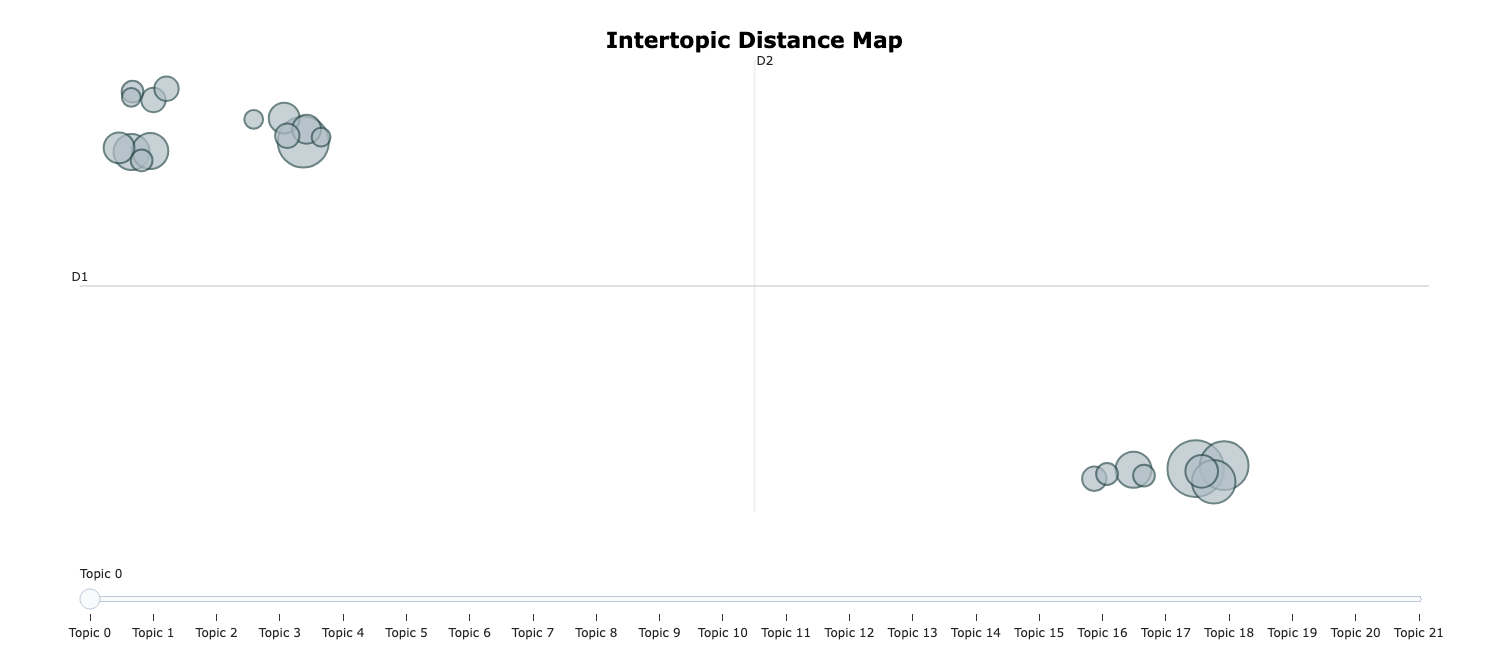

In [15]:
# run this cell to visualize the topics
topic_model.visualize_topics()